음악 녹음에서 가장 대표적인 섹션을 자동으로 결정하는 오디오 썸네일(thumbnail)에 대해 다룬다. 세그먼트의 반복 기반 접근 방식의 최적화 방법을 알아본다.

In [28]:
import numpy as np
import math
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import IPython.display as ipd
import pandas as pd
import librosa, librosa.display

from utils.feature_tools import normalize_feature_sequence, smooth_downsample_feature_sequence, median_downsample_feature_sequence
from utils.plot_tools import plot_matrix, compressed_gray_cmap, plot_chromagram, plot_segments, plot_segments_overlay
from utils.structure_tools import compute_sm_from_filename, compute_tempo_rel_set, read_structure_annotation

# 오디오 썸네일 (Audio Thumbnail)

- 음악 구조 분석의 중요한 하위 문제로 **오디오 썸네일링(thumbnailing)** 이 있다. 음악 녹음에서 가장 대표적인 섹션을 자동으로 결정하는 것이며, 이는 청취자에게 노래 또는 음악 작품에 대한 첫인상을 주는 일종의 "미리 보기" 역할을 할 수 있다. 
- 이러한 미리 보기를 기반으로 사용자는 노래를 듣고 싶은지 또는 다음 녹음으로 이동할지 빠르게 결정할 수 있어야 한다. 
- 따라서 오디오 썸네일은 대규모 음악 컬렉션에서 흥미로운 부분을 찾는 데 중요한 탐색 및 탐색 보조 도구이다. 이 포스트에서는 **반복 기반 접근 방식(repetition-based approach)** 을 설명한다.

- 종종 후렴구 또는 노래의 메인 테마와 같은 섹션은 오디오 썸네일의 좋은 후보이다. 이러한 부분은 일반적으로 녹음 내내 여러 번 반복된다. 
- 따라서 썸네일을 자동으로 결정하기 위한 대부분의 절차는 특정 최소 기간이 있으면서 **많은 (대략적인) 반복**이 있는 섹션을 식별하는 것이다. 
- 다음 그림은 서양 음악에서 볼 수 있는 음악 구조의 몇 가지 예를 보여준다. 
    - 론도는 당연히 썸네일 후보가 테마(A파트)이다. 소나타는 제시부의 시작 부분(파트 E1, E2 및 R에서 발생)은 적절한 썸네일 축소판일 수 있다. 'Yesterday'와 같은 팝송은 벌스 섹션(V1 파트)이 특징이다. 마지막으로 이전 실행 예제로 이미 봤던 Brahms 예제에서는 A 파트 또는 B 파트를 썸네일로 선택할 수 있다.

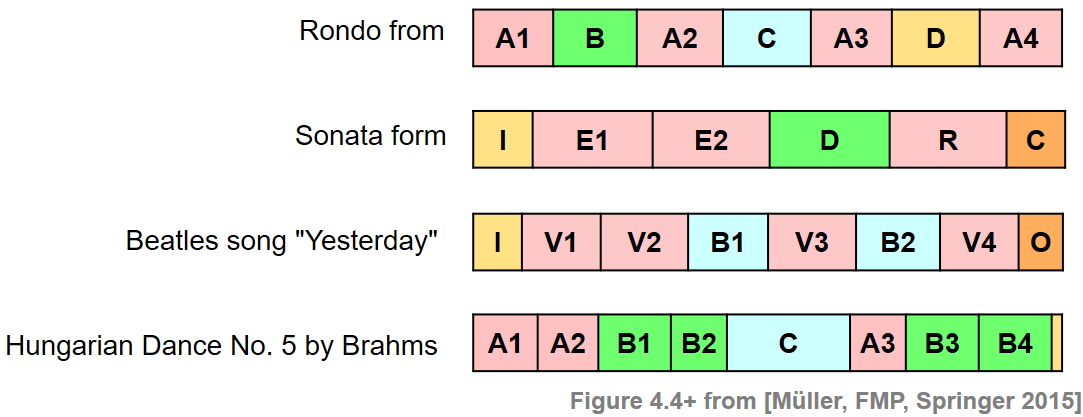

In [14]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F04+.png", width=600)

- 한 가지 문제는 반복되는 섹션이 다이나믹(dynamics), 악기 편성, 아티큘레이션 및 템포와 관련된 측면에서 상당한 음향 및 음악적 차이를 보일 수 있다는 것이다. 
- 따라서 주어진 음악 녹음에서 반복적인 세그먼트를 추출하기 위한 썸네일링 절차는 특정 변형에 robust해야 한다. 

- 이제 음악적, 템포적인 변동을 다루기 위해, 향상된 자기 유사성 행렬(SSM)과 타임 워핑(time warping) 기술을 기반으로 하는 절차를 설명한다. 주요 기술 도구로 각 오디오 세그먼트에 적합도(fitness) 값을 할당하는 **적합도 측정(fitness measure)** 을 소개한다. 이 측정은 두 가지 측면을 동시에 포착한다. 첫째, 주어진 세그먼트가 다른 관련 세그먼트를 **얼마나 잘** 설명하는지를 나타내고, 둘째, 이러한 모든 관련 세그먼트가 전체 음악 녹음의 **얼마나 많은** 부분을 포함하는지 나타낸다. 그런 다음 **오디오 썸네일**은 **최대 적합도 세그먼트**로 정의된다.

## SSM의 필요조건

- 적합도(fitness) 측정의 아이디어는 주어진 세그먼트와 그것의 대략적인 반복 간의 모든 관계를 동시에 설정하는 것이다. 이를 위해서는 **자기 유사성 행렬(SSM)** 이 필요하다. 적합도 측정에 대한 다음 설명은 일부 기본 **정규화 속성(normalization properties)** 만 충족하는 일반 자기 유사성 행렬과 함께 작동한다는 점에서 일반적이다. 
$$\mathbf{S}(n,m)\leq 1 \text{ and } \mathbf{S}(n,n)=1 \text{ for all } n,m\in[1:N]$$


- [5.2. 자기 유사성 행렬](https://jo-cho.github.io/MIRBlog/posts/5.%20Music%20Structure%20Analysis/5.2.Self_Similarity_Matrix.html)에서 사용한 브람스 예시를 계속하여 보면, 향상된(enhanced) SSM에서 시작하여 정규화 속성을 만족시키는 임계값 절차(thresholding procedure)를 거친다. 결과적으로 SSM의 모든 상관있는(relevant) 성분은 0과 1 사이(주대각선 성분은 1)가 되며, 상관없는 성분은 $\delta=-2$의 음수 점수를 가진다.

In [15]:
def colormap_penalty(penalty=-2, cmap=compressed_gray_cmap(alpha=5)):
    """Extend colormap with white color between the penalty value and zero

    Args:
        penalty (float): Negative number (Default value = -2.0)
        cmap (mpl.colors.Colormap): Original colormap (Default value = libfmp.b.compressed_gray_cmap(alpha=5))

    Returns:
        cmap_penalty (mpl.colors.Colormap): Extended colormap
    """
    if isinstance(cmap, str):
        cmap = matplotlib.cm.get_cmap(cmap, 128)
    cmap_matrix = cmap(np.linspace(0, 1, 128))[:, :3]
    num_row = int(np.abs(penalty)*128)
    # cmap_penalty = np.flip(np.concatenate((cmap_matrix, np.ones((num_row, 3))), axis=0), axis=0)
    cmap_penalty = np.concatenate((np.ones((num_row, 3)), cmap_matrix), axis=0)
    cmap_penalty = ListedColormap(cmap_penalty)

    return cmap_penalty


def normalization_properties_ssm(S):
    """Normalizes self-similartiy matrix to fulfill S(n,n)=1.
    Yields a warning if max(S)<=1 is not fulfilled

    Args:
        S (np.ndarray): Self-similarity matrix (SSM)

    Returns:
        S_normalized (np.ndarray): Normalized self-similarity matrix
    """
    S_normalized = S.copy()
    N = S_normalized.shape[0]
    for n in range(N):
        S_normalized[n, n] = 1
        max_S = np.max(S_normalized)
    if max_S > 1:
        print('Normalization condition for SSM not fulfill (max > 1)')
    return S_normalized

In [16]:
def plot_ssm_ann(S, ann, Fs=1, cmap='gray_r', color_ann=[], ann_x=True, ann_y=True,
                 fontsize=12, figsize=(5, 4.5), xlabel='', ylabel='', title=''):
    """Plot SSM and annotations (horizontal and vertical as overlay)

    Args:
        S: Self-similarity matrix
        ann: Annotations
        Fs: Feature rate of path_family (Default value = 1)
        cmap: Color map for S (Default value = 'gray_r')
        color_ann: color scheme used for annotations (see :func:`libfmp.b.b_plot.plot_segments`)
            (Default value = [])
        ann_x: Plot annotations on x-axis (Default value = True)
        ann_y: Plot annotations on y-axis (Default value = True)
        fontsize: Font size used for annotation labels (Default value = 12)
        figsize: Size of figure (Default value = (5, 4.5))
        xlabel: Label for x-axis (Default value = '')
        ylabel: Label for y-axis (Default value = '')
        title: Figure size (Default value = '')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05],
                                              'height_ratios': [1, 0.1]}, figsize=figsize)

    fig_im, ax_im, im = plot_matrix(S, Fs=Fs, Fs_F=Fs,
                                             ax=[ax[0, 0], ax[0, 1]], cmap=cmap,
                                             xlabel='', ylabel='', title='')
    ax[0, 0].set_ylabel(ylabel)
    ax[0, 0].set_xlabel(xlabel)
    ax[0, 0].set_title(title)
    if ann_y:
        plot_segments_overlay(ann, ax=ax_im[0], direction='vertical',
                                       time_max=S.shape[0]/Fs, print_labels=False,
                                       colors=color_ann, alpha=0.05)
    if ann_x:
        plot_segments(ann, ax=ax[1, 0], time_max=S.shape[0]/Fs, colors=color_ann,
                               time_axis=False, fontsize=fontsize)
    else:
        ax[1, 0].axis('off')
    ax[1, 1].axis('off')
    plt.tight_layout()
    return fig, ax, im

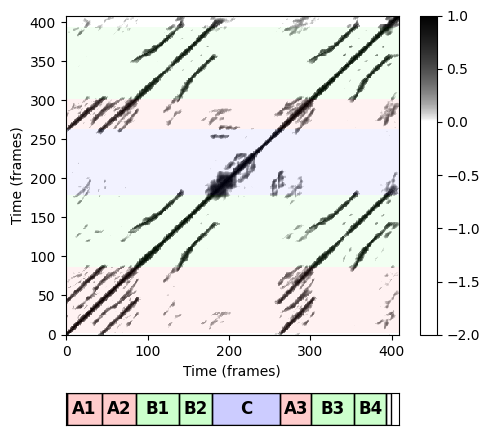

In [17]:
fn_wav = '../data_FMP/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.wav'

tempo_rel_set = compute_tempo_rel_set(0.66, 1.5, 5)
penalty = -2
x, x_duration, X, Fs_feature, S, I = compute_sm_from_filename(fn_wav, L=21, H=5, 
                        L_smooth=12, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh=0.15)
S = normalization_properties_ssm(S)
 
fn_ann = '../data_FMP/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.csv'
ann_frames, color_ann = read_structure_annotation(fn_ann, Fs=Fs_feature)

cmap_penalty = colormap_penalty(penalty=penalty)
fig, ax, im = plot_ssm_ann(S, ann_frames, Fs=1, color_ann=color_ann, cmap=cmap_penalty, 
                       xlabel='Time (frames)', ylabel='Time (frames)')

In [18]:
S.shape

(409, 409)

## 경로군 (Path Family)

- $P=((n_1,m_1), (n_2,m_2), \ldots,(n_L,m_L))$를 주어진 **세그먼트** $\alpha=[s:t]\subseteq [ 1:N]$의 경로(path)라고 하고, $\Sigma$를 기본 **허용 가능한 step size 집합**을 나타낸다고 하자. 그러면 정의에 따라 $m_1=s$ 및 $m_L=t$ 이고, 경로 $P$는 $\alpha=\pi_2(P)$와 유도된(induced) 세그먼트 $\pi_1(P)$ 사이의 관계를 인코딩한다. 

- 경로의 개념을 확장하여 이제 음악 녹음에서 $\alpha$와 다른 여러 세그먼트 간의 관계를 캡처할 수 있는 경로군(path family)의 개념을 소개한다. 이를 위해 먼저 $K$ 크기의 **세그먼트 군**(**segment family**)을 다음의 집합으로 정의한다.
$$\mathcal{A}:=\{\alpha_1,\alpha_2,\ldots,\alpha_K\}$$

- 즉, $k\not= j$인 모든 $k,j\in[1:K]$에 대해 $\alpha_k\cap\alpha_j=\emptyset$이다. $\alpha$ 위의 **경로군**는 다음의 집합으로 정의된다.
$$\mathcal{P}:=\{P_1,P_2,\ldots,P_K\}$$
    - of size $K$, 
    - consisting of paths $P_k$ over $\alpha$ for $k\in[1:K]$
    
- 또한 추가 조건으로 유도된 세그먼트가 "pairwise disjoint"이어야 한다. 즉, $\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$ 집합이 세그먼트 군이 되어야 한다.
- 이러한 정의는 다음의 그림으로 설명된다.
    - (왼쪽부터) 세그먼트 $\alpha$가 있는 SSM / 세 개의 경로로 구성된 $\alpha$ 위에 경로군가 있이 SSM / 경로군이 **아닌** 경로들(유도된 세그먼트가 겹치기 때문에) / 두 개의 경로로 구성된 경로군

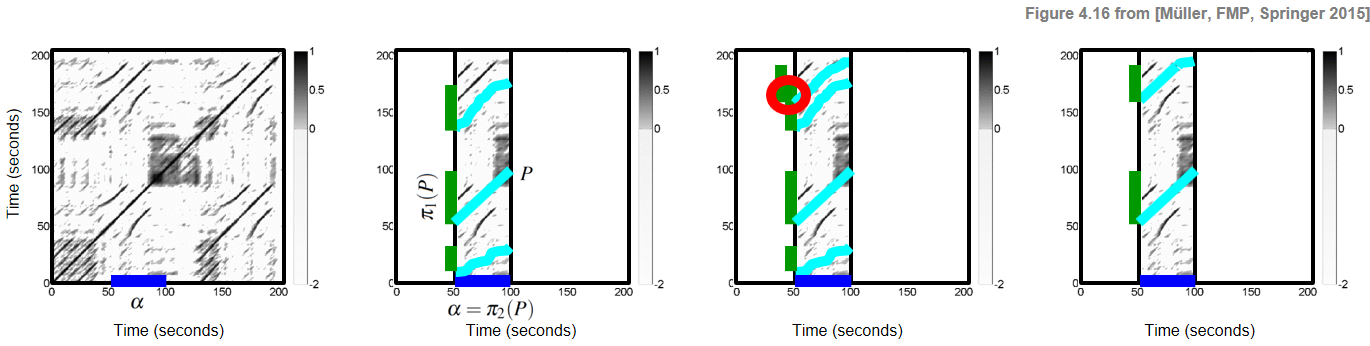

In [19]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F16.png", width=1000)

In [32]:
def plot_path_family(ax, path_family, Fs=1, x_offset=0, y_offset=0, proj_x=True, w_x=7, proj_y=True, w_y=7):
    """Plot path family into a given axis

    Args:
        ax: Axis of plot
        path_family: Path family
        Fs: Feature rate of path_family (Default value = 1)
        x_offset: Offset x-axis (Default value = 0)
        y_offset: Yffset x-axis (Default value = 0)
        proj_x: Display projection on x-axis (Default value = True)
        w_x: Width used for projection on x-axis (Default value = 7)
        proj_y: Display projection on y-axis (Default value = True)
        w_y: Width used for projection on y-axis (Default value = 7)
    """
    for path in path_family:
        y = [(path[i][0] + y_offset)/Fs for i in range(len(path))]
        x = [(path[i][1] + x_offset)/Fs for i in range(len(path))]
        ax.plot(x, y, "o", color=[0, 0, 0], linewidth=3, markersize=5)
        ax.plot(x, y, '.', color=[0.7, 1, 1], linewidth=2, markersize=6)
    if proj_y:
        for path in path_family:
            y1 = path[0][0]/Fs
            y2 = path[-1][0]/Fs
            ax.add_patch(plt.Rectangle((0, y1), w_y, y2-y1, linewidth=1,
                                       facecolor=[0, 1, 0], edgecolor=[0, 0, 0]))
            # ax.plot([0, 0], [y1, y2], linewidth=8, color=[0, 1, 0])
    if proj_x:
        for path in path_family:
            x1 = (path[0][1] + x_offset)/Fs
            x2 = (path[-1][1] + x_offset)/Fs
            ax.add_patch(plt.Rectangle((x1, 0), x2-x1, w_x, linewidth=1,
                                       facecolor=[0, 0, 1], edgecolor=[0, 0, 0]))
            # ax.plot([x1, x2], [0, 0], linewidth=8, color=[0, 0, 1])                 

Segment: [20, 80]


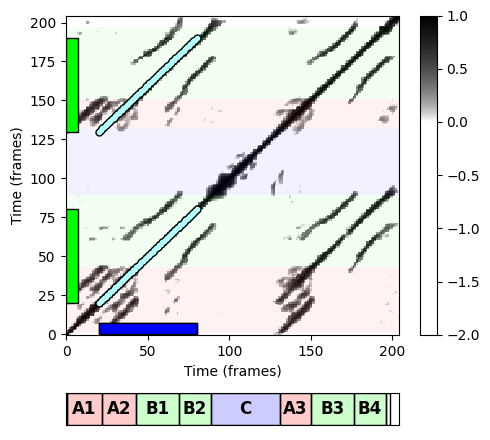

In [33]:
# Manually defined path family
# For implementation reasons, the seconds components are of the paths 
# start with index 0 (corresponding to seg[0])
seg_sec = [20, 80]
seg = [int(seg_sec[0]*Fs_feature), int(seg_sec[1]*Fs_feature)]
path_1 = [np.array([i+seg[0],i]) for i in range(0, seg[-1]-seg[0]+1)]
path_2 = [np.array([int(i+130*Fs_feature),i]) for i in range(0, seg[-1]-seg[0]+1)]
path_family = [path_1, path_2]
print('Segment:', seg)
fig, ax, im = plot_ssm_ann(S, ann_frames, Fs=1, color_ann=color_ann, cmap=cmap_penalty, 
                       xlabel='Time (frames)', ylabel='Time (frames)') 
plot_path_family(ax[0,0], path_family, Fs=1, x_offset=seg[0])

## 커버리지 (Coverage)

- 이제 경로군 $\mathcal{P}$의 특정 속성을 설명하는 몇 가지 측정값을 정의한다. 
- $\mathcal{A}:=\{\alpha_1,\alpha_2,\ldots,\alpha_K\}$를 세그먼트 군이라고 하자.
- $\mathcal{A}$의 **커버리지/반영범위(coverage)** $\gamma(\mathcal{A})$는 다음과 같이 정의된다.
$$\gamma(\mathcal{A}):=\sum_{k=1}^K|\alpha_k|$$

- 또한, 경로군 $\mathcal{P}=\{P_1,P_2,\ldots,P_K\}$의 범위 $\gamma(\mathcal{P})$는 유도된 세그먼트 군 $\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$의 커버리지로 정의된다. 
- 다음 코드에서 유도된 세그먼트군과 주어진 경로군에 대한 커버리지를 유도하는 함수를 제공한다. 이 함수는 위에서 생성한 경로군에 적용된다.

In [34]:
def compute_induced_segment_family_coverage(path_family):
    """Compute induced segment family and coverage from path family

    Args:
        path_family (list): Path family

    Returns:
        segment_family (np.ndarray): Induced segment family
        coverage (float): Coverage of path family
    """
    num_path = len(path_family)
    coverage = 0
    if num_path > 0:
        segment_family = np.zeros((num_path, 2), dtype=int)
        for n in range(num_path):
            segment_family[n, 0] = path_family[n][0][0]
            segment_family[n, 1] = path_family[n][-1][0]
            coverage = coverage + segment_family[n, 1] - segment_family[n, 0] + 1
    else:
        segment_family = np.empty

    return segment_family, coverage

In [35]:
segment_family, coverage = compute_induced_segment_family_coverage(path_family)
print('Segment (alpha):', seg)
print('Induced segment family:')
print(segment_family)
print('Coverage: %d'%coverage)    

Segment (alpha): [20, 80]
Induced segment family:
[[ 20  80]
 [130 190]]
Coverage: 122


## 점수와 최적 (Score and Optimality)

- 다음으로 점수(score)의 개념을 경로에서 경로군로 전환한다. 주어진 SSM $\mathbf{S}$에서 경로 $P$의 **점수** $\sigma(P)$는 다음과 같이 정의된다.
$$\sigma(P)=\sum_{\ell=1}^L \mathbf{S}(n_\ell,m_\ell).$$

- 이 값은 세그먼트 $\pi_1(P)$와 $\pi_2(P)$ 사이의 유사성 관계에 대한 품질 척도로 생각할 수 있다. 경로군 $\mathcal{P}$의 경우 **점수** $\sigma(\mathcal{P})$는 다음과 같이 정의된다.
$$\sigma(\mathcal{P}) := \sum_{k=1}^{K} \sigma(P_k).$$

- 큰 점수 $\sigma(\mathcal{P})$는 $\mathcal{P}$의 경로 구성 요소가 해당 세그먼트 간에 강력한 유사성 관계를 표현함을 나타낸다.

- 일반적으로 많은 수의 $\alpha$ 위로의 가능한 경로군가 있다. 이러한 경로군 중에서 $\mathcal{P}^\ast := \underset{\mathcal{P}}{\mathrm{argmax}} \,\,\, \sigma(\mathcal{P})$를 최대 점수의 최적 경로군을 나타낸다고 하자. 

- 다음에서는 $\mathcal{P}^\ast$ 경로에 의해 유도된(induced) 세그먼트로 구성된 것을 **유도된(induced) 세그먼트 군** (of $\mathcal{P}^\ast$ 또는 간단히 $\alpha$)이라고 한다. 직관적으로, 유도된 세그먼트 군은 세그먼트 $\alpha$의 (겹치지 않는) 반복을 포함한다.

## 최적 경로군 계산 (Computation of Optimal Path Families)

- 최적 워핑 경로를 계산하는 DTW(dynamic time warping)과 유사하게 동적(dynamic) 프로그래밍을 사용하여 최적 경로군 $\mathcal{P}^\ast$를 계산하는 효율적인 알고리즘이 있다. 

- 다음 코드에서 허용 가능한 step size의 $\Sigma = \{(2,1),(1,2),(1,1)\}$ 집합을 사용하여 이 알고리즘의 구현한다. 

- $\mathbf{S}$를 필요한 정규화 속성(**점수 매트릭스**라고도 함)과 세그먼트 $\alpha=[s:t]\subseteq [ 1:N]$와 $M:=|\alpha|$을 충족하는 $N$-square SSM이라고 하자. 

- 알고리즘의 입력(input)은 $\mathbf{S}$의 열 $s$에서 $t$로 구성된 $N\times M$ 부분행렬(submatrix) $\mathcal{S}^{\alpha}$이다. 

- 먼저 동적 프로그래밍을 사용하여 **누적 점수 매트릭스** $D$를 계산한다.

In [36]:
def compute_accumulated_score_matrix(S_seg):
    """Compute the accumulated score matrix

    Args:
        S_seg (np.ndarray): Submatrix of an enhanced and normalized SSM ``S``.
            Note: ``S`` must satisfy ``S(n,m) <= 1 and S(n,n) = 1``

    Returns:
        D (np.ndarray): Accumulated score matrix
        score (float): Score of optimal path family
    """
    inf = math.inf
    N = S_seg.shape[0]
    M = S_seg.shape[1]+1

    # Iinitializing score matrix
    D = -inf * np.ones((N, M), dtype=np.float64)
    D[0, 0] = 0.
    D[0, 1] = D[0, 0] + S_seg[0, 0]

    # Dynamic programming
    for n in range(1, N):
        D[n, 0] = max(D[n-1, 0], D[n-1, -1])
        D[n, 1] = D[n, 0] + S_seg[n, 0]
        for m in range(2, M):
            D[n, m] = S_seg[n, m-1] + max(D[n-1, m-1], D[n-1, m-2], D[n-2, m-1])

    # Score of optimal path family
    score = np.maximum(D[N-1, 0], D[N-1, M-1])

    return D, score

- 다음으로, 역추적(backtracking)을 이용하여 최적 경로군 $\mathcal{P}^\ast$를 도출한다. 

In [37]:
def compute_optimal_path_family(D):
    """Compute an optimal path family given an accumulated score matrix

    Args:
        D (np.ndarray): Accumulated score matrix

    Returns:
        path_family (list): Optimal path family consisting of list of paths
            (each path being a list of index pairs)
    """
    # Initialization
    inf = math.inf
    N = int(D.shape[0])
    M = int(D.shape[1])

    path_family = []
    path = []

    n = N - 1
    if(D[n, M-1] < D[n, 0]):
        m = 0
    else:
        m = M-1
        path_point = (N-1, M-2)
        path.append(path_point)

    # Backtracking
    while n > 0 or m > 0:

        # obtaining the set of possible predecesors given our current position
        if(n <= 2 and m <= 2):
            predecessors = [(n-1, m-1)]
        elif(n <= 2 and m > 2):
            predecessors = [(n-1, m-1), (n-1, m-2)]
        elif(n > 2 and m <= 2):
            predecessors = [(n-1, m-1), (n-2, m-1)]
        else:
            predecessors = [(n-1, m-1), (n-2, m-1), (n-1, m-2)]

        # case for the first row. Only horizontal movements allowed
        if n == 0:
            cell = (0, m-1)
        # case for the elevator column: we can keep going down the column or jumping to the end of the next row
        elif m == 0:
            if D[n-1, M-1] > D[n-1, 0]:
                cell = (n-1, M-1)
                path_point = (n-1, M-2)
                if(len(path) > 0):
                    path.reverse()
                    path_family.append(path)
                path = [path_point]
            else:
                cell = (n-1, 0)
        # case for m=1, only horizontal steps to the elevator column are allowed
        elif m == 1:
            cell = (n, 0)
        # regular case
        else:

            # obtaining the best of the possible predecesors
            max_val = -inf
            for i, cur_predecessor in enumerate(predecessors):
                if(max_val < D[cur_predecessor[0], cur_predecessor[1]]):
                    max_val = D[cur_predecessor[0], cur_predecessor[1]]
                    cell = cur_predecessor

            # saving the point in the current path
            path_point = (cell[0], cell[1]-1)
            path.append(path_point)

        (n, m) = cell

    # adding last path to the path family
    path.reverse()
    path_family.append(path)
    path_family.reverse()

    return path_family

- 다음 그림에서 부분 행렬 $\mathcal{S}^{\alpha}$와 세그먼트 $\alpha=[83:137]$ (`seg = [82, 136]`)에 대한 누적 점수 행렬 $D$가 나타나 있다. 
- $2~\mathrm{Hz}$의 프레임 속도(frame rate)를 사용하여 이 세그먼트는 $41$에서 $68$초 범위의 간격에 해당하며 대략적으로 Brahms 레코딩의 $B_1$ 부분이다. 다음 사항에 유의하자.
    * 부분 행렬 $\mathcal{S}^{\alpha}$의 열 수는 $M=55$이다.
    * Python 구현에서 $\mathcal{S}^{\alpha}$의 열은 인덱스 `0`부터 인덱스 `M-1`까지 열거된다.
    * 행렬 $D$에는 소위 엘리베이터(elevator) 컬럼을 포함하는 $M+1$ 컬럼이 있다.
    * 단계 크기(step size) 조건 $\Sigma = \{(2,1),(1,2),(1,1)\}$를 사용하면, 경로가 로컬 템포 차이에 적응할 수 있다.
    * 최적의 경로군은 4개의 경로로 구성된다. 유도된(induced) 세그먼트는 Brahms 녹음의 4개의 $B$ 파트 섹션에 대략 해당된다.

Segment: [41, 68]
Length of segment: M =  28


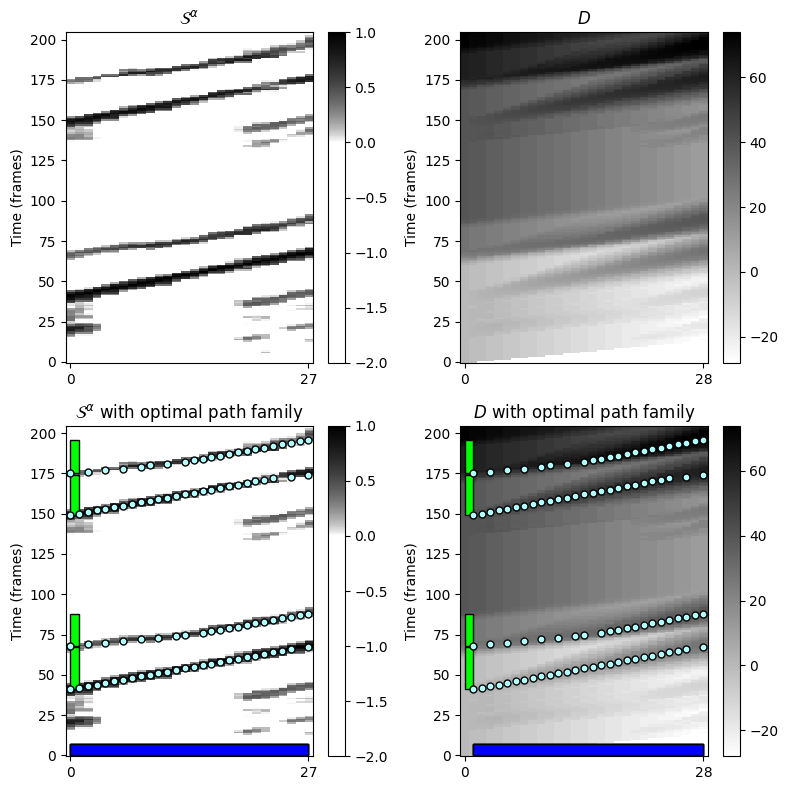

In [38]:
def plot_matrix_seg(ax, M, seg, title='', xlabel='', cmap='gray_r'):
    plot_matrix(M, Fs=1, ax=[ax], cmap=cmap, 
        xlabel=xlabel, ylabel='Time (frames)', title=title)
    ax.set_xticks([0, M.shape[1]-1])    
    
seg_sec = [41,68]
seg = [int(seg_sec[0]*Fs_feature), int(seg_sec[1]*Fs_feature)]
print('Segment:', seg)
print('Length of segment: M = ', seg[1]-seg[0]+1)
S_seg = S[:,seg[0]:seg[1]+1]
D, score = compute_accumulated_score_matrix(S_seg)
path_family = compute_optimal_path_family(D)

plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 2, 1)
title = r'$\mathcal{S}^{\alpha}$'
plot_matrix_seg(ax, S_seg, seg, title=title, xlabel='', cmap=cmap_penalty)

ax = plt.subplot(2, 2, 2)
title = r'$D$'
plot_matrix_seg(ax, D, seg, title=title)

ax = plt.subplot(2, 2, 3)
title = r'$\mathcal{S}^{\alpha}$ with optimal path family'
plot_matrix_seg(ax, S_seg, seg, title=title, xlabel='', cmap=cmap_penalty)
plot_path_family(ax, path_family, x_offset=0, w_y=1)

ax = plt.subplot(2, 2, 4)
title = r'$D$ with optimal path family'
plot_matrix_seg(ax, D, seg, title=title)
plot_path_family(ax, path_family, x_offset=1, w_y=1)

plt.tight_layout()

## 적합도 측정 (Fitness Measure)

- 주어진 세그먼트 $\alpha$에 대해, $\mathcal{P}^\ast=\{P_1,\ldots,P_K\}$를 최적 경로군이라고 하자. 이제 $\sigma(\mathcal{P}^\ast)$ 점수와 $\mathcal{P}^\ast$의 유도된 세그먼트 군에서 적합도(fitness) 측정을 유도하는 방법을 설명한다.


- 첫 번째, 총 점수 $\sigma(\mathcal{P}^\ast)$를 $\alpha$의 적합도 값으로 사용한다. 그러나 이 측정은 $\alpha$의 길이와 경로에 의존할 뿐만 아니라 당연한 자체-설명(self-explanation)도 캡처하기 때문에 아직 원하는 속성을 갖지 않는다.
    - 예를 들어 $\alpha=[1:N]$ 세그먼트는 전체 시퀀스 $X$를 완벽하게 설명하며 이는 당연한 사실이다. 좀 더 일반적으로 각 세그먼트 $\alpha$는 자기 유사성 행렬의 주 대각선으로 인코딩된 정보를 완벽하게 설명한다.

- 따라서 적합도 측정을 정의할 때의 한 가지 방법은 이러한 당연한 자기-설명(trivial self-explanation)을 무시하는 것이다.
    - 정규화 속성 $\mathbf{S}(n,m)\leq 1$ 및 $\mathbf{S}(n,n)=1$를 가정하면, $\sigma(\mathcal{P}^\ast)$ 점수에서 $|\alpha|$ 길이를 빼는 방법을 사용할 수 있다.

- 또한 최적 경로군 $\mathcal{P}^\ast$에 포함된 경로 $P_k$의 길이 $L_k:=|P_k|$에 대한 점수를 정규화한다.
    - 다음과 같이 정의된 **정규화 점수(normalized score)** $\bar{\sigma}(\alpha)$를 산출한다.
$$\bar{\sigma}(\alpha) := \frac{\sigma(\mathcal{P}^\ast) - |\alpha|}{\sum_{k=1}^{K} L_k}$$
     
- 직관적으로 $\bar{\sigma}(\alpha)$ 값은 최적 경로군 $\mathcal{P}^\ast$의 **평균 점수**를 나타낸다.

- 정규화 **점수**는 주어진 세그먼트가 다른 세그먼트를 **얼마나 잘** 설명하는지를 나타내며, 여기서 정규화는 세그먼트 길이의 영향을 제거한다. 이렇게 하면 길이가 다른 세그먼트를 비교할 때 정규화된 점수가 공정한 측정이 될 수 있다.

- 반복성 외에 또 다른 문제는 썸네일 및 썸네일 관련 세그먼트가 기본 음악 녹음을 **얼마나 많이 (how much)** 포함하는지이다.
- 이 속성을 포착하기 위해 주어진 $\alpha$에 대한 **커버리지(coverage)** 측정을 정의한다.
- 이를 위해 $\mathcal{A}^\ast:=\{\pi_1(P_1),\ldots,\pi_1(P_K)\}$를 최적 경로군 $\mathcal{P}^\ast$에 의해 유도된 세그먼트 군이라고 하고, $\gamma(\mathcal{A}^\ast)$를 그것의 커버리지라고 하자.


- 그런 다음 **정규화 커버리지** $\bar{\gamma}(\alpha)$를 다음과 같이 정의한다.
$$\bar{\gamma}(\alpha) := \frac{\gamma(\mathcal{A}^\ast) - |\alpha|}{N}.$$
     
     
- 위와 같이 사소한(trivial) 커버리지에 대해 $|\alpha|$ 길이를 뺀다.
- $\bar{\gamma}(\alpha)$ 값은 $\alpha$의 유도된 세그먼트의 합집합과 원본 녹음의 전체 길이 사이의 비율을 나타낸다(자기-설명의 비율을 뺀 값).

- 높은 평균 점수와 높은 커버리지는 썸네일 세그먼트를 정의하는 데 바람직한 속성이다. 그러나 이 두 가지 속성을 동시에 만족시키기 어려운 경우가 있다. 
- 세그먼트가 짧을수록 평균 점수는 더 높지만 커버리지는 더 낮고, 길이가 더 긴 세그먼트는 평균 점수가 더 낮지만 커버리지가 더 높은 경향이 있다.

- 이 두 추세의 균형을 맞추기 위해 적절한 평균을 취하여 점수와 커버리지 측정을 결합한다.
- 특히 세그먼트 $\alpha$의 **적합도(fitness)** $\varphi(\alpha)$를 정규화된 점수와 정규화된 커버리지 사이의 **조화 평균 (harmonic mean)** 을 $$\varphi(\alpha) := 2\cdot \frac{\bar{\sigma}(\alpha) \cdot \bar{\gamma}(\alpha)}{\bar{\sigma}(\alpha)+\bar{\gamma}(\alpha )}$$ 라고 정의한다.
- 정규화된 값 $\bar{\sigma}(\alpha)$ 및 $\bar{\gamma}(\alpha)$를 기반으로, $\varphi(\alpha)\leq 1-|\alpha |/N$ 임을 보일 수 있다.

- 다음 코드 셀에서는 이전 코드 셀에서 고려한 경로군에 대해 이러한 다양한 측정값을 계산한다.

In [39]:
def compute_fitness(path_family, score, N):
    """Compute fitness measure and other metrics from path family

    Args:
        path_family (list): Path family
        score (float): Score
        N (int): Length of feature sequence

    Returns:
        fitness (float): Fitness
        score (float): Score
        score_n (float): Normalized score
        coverage (float): Coverage
        coverage_n (float): Normalized coverage
        path_family_length (int): Length of path family (total number of cells)
    """
    eps = 1e-16
    num_path = len(path_family)
    M = path_family[0][-1][1] + 1

    # Normalized score
    path_family_length = 0
    for n in range(num_path):
        path_family_length = path_family_length + len(path_family[n])
    score_n = (score - M) / (path_family_length + eps)

    # Normalized coverage
    segment_family, coverage = compute_induced_segment_family_coverage(path_family)
    coverage_n = (coverage - M) / (N + eps)

    # Fitness measure
    fitness = 2 * score_n * coverage_n / (score_n + coverage_n + eps)

    return fitness, score, score_n, coverage, coverage_n, path_family_length

In [40]:
N = S.shape[0]

segment_family, coverage = compute_induced_segment_family_coverage(path_family)
fitness, score, score_n, coverage, coverage_n, path_family_length = compute_fitness(
    path_family, score, N)

print('Segment (alpha):', seg)
print('Length of segment:', seg[-1]-seg[0]+1)
print('Length of feature sequence:', N)
print('Induced segment path family:\n', segment_family)
print('Fitness: %0.3f'%fitness) 
print('Score: %0.3f'%score) 
print('Normalized score: %0.3f'%score_n) 
print('Coverage: %d'%coverage) 
print('Normalized coverage: %0.3f'%coverage_n) 
print('Length of all paths of family: %d'%path_family_length)

Segment (alpha): [41, 68]
Length of segment: 28
Length of feature sequence: 205
Induced segment path family:
 [[ 41  67]
 [ 68  88]
 [149 174]
 [175 196]]
Fitness: 0.392
Score: 73.857
Normalized score: 0.478
Coverage: 96
Normalized coverage: 0.332
Length of all paths of family: 96


## 썸네일 선정 (Thumbnail Selection)

- 적합도 측정을 기반으로 구한 **오디오 썸네일**을 **최대 적합도(maximizing-fitness)** 세그먼트로 정의한다.
$$\alpha^\ast := \underset{\alpha}{\mathrm{argmax}} \,\, \varphi(\alpha)$$

- 적합도 측정으로 이 세그먼트는 오디오 녹음의 "가능한 많은 부분을 포함하는 겹치지 않는 반복"을 가지게 된다. 또한 이러한 반복은 오디오 녹음을 "pairwise disjoint" 세그먼트로 분할하는 $\alpha^\ast$의 최적 경로군으로 얻은 유도된 세그먼트에 의해 주어진다.


- 사전 지식을 설명하고 잘못된 추정을 제거하기 위해 썸네일 솔루션에 추가 요구 사항을 부과할 수 있다. 가능한 최소 썸네일 길이에 대한 하한 $\theta$를 도입하면 자기 유사성 행렬(SSM)에 분산된 노이즈의 영향을 줄일 수 있다. 위의 정의를 확장하여 $\alpha^\ast_\theta := \underset{\alpha, |\alpha|\geq \theta}{\mathrm{argmax}} \,\, \varphi(\alpha)$를 정의한다. 

- 오디오 썸네일 계산에는 가능한 모든 세그먼트 $\alpha$에 대한 적합도 측정 계산이 포함된다.
- 적합도 최대화 세그먼트를 선택하는 것 외에도 모든 세그먼트에 대한 적합도 값의 시각화는 매우 유익하며 음악 녹음의 구조적 속성에 대한 음악적 통찰력을 제공한다. 그 중 scape plot에 대해 뒤에서 다룰 것이며, 여기서 적합도 측정의 추가 속성에 대해서도 논의하기로 한다.

# 스케이프 플롯 (Scape Plot)

## 세그먼트의 삼각형 표현(Triangular Representation)

- 위에서 오디오 썸네일링의 맥락에서 세그먼트 특정의 속성을 표현하는 적합도(fitness) 값을 가능한 각 세그먼트에 할당하도록 적합도 측정을 계산했다. 

- 이제 세그먼트 의존적(segment-dependent) 속성을 간결하고(compact) 계층적인(hierarchical) 방식으로 시각화할 수 있는 표현을 소개한다. 

- **세그먼트** $\alpha=[s:t]\subseteq [1:N]$는 시작점 $s$와 끝점 $t$에 의해 고유하게 결정된다. $s\leq t$인 임의의 두 숫자 $s,t\in[1:N]$가 세그먼트를 정의하므로, $(N+1)N/2$개의 다른 세그먼트가 있다고 볼 수 있다. 

- 시작점과 끝점을 고려하는 대신 각 세그먼트를 그것의 중심(center) $c(\alpha):=(s+t)/2$과 길이 $|\alpha|$로 고유하게 설명할 수도 있다. 중심을 사용하여 수평 축을 매개변수화하고, 길이를 사용하여 높이를 매개변수화하면 각 세그먼트는 **삼각형 표현(triangular representation)** 의 점으로 표시될 수 있다.

- 이렇게 하면 세그먼트 집합이 길이에 따라 계층적 방식으로 아래에서 위로 정렬된다. 특히, 이 삼각형의 상단은 최대 길이 $N$의 고유 세그먼트에 해당하고, 삼각형의 하단 점은 길이가 1인 $N$ 세그먼트에 해당한다(시작점과 끝점이 일치함). 또한 주어진 세그먼트 $\alpha$에 포함된 모든 세그먼트 $\alpha'\subseteq\alpha$는 $\alpha$로 주어진 점 아래의 하위 삼각형에 있는 삼각형 표현의 점에 해당한다.

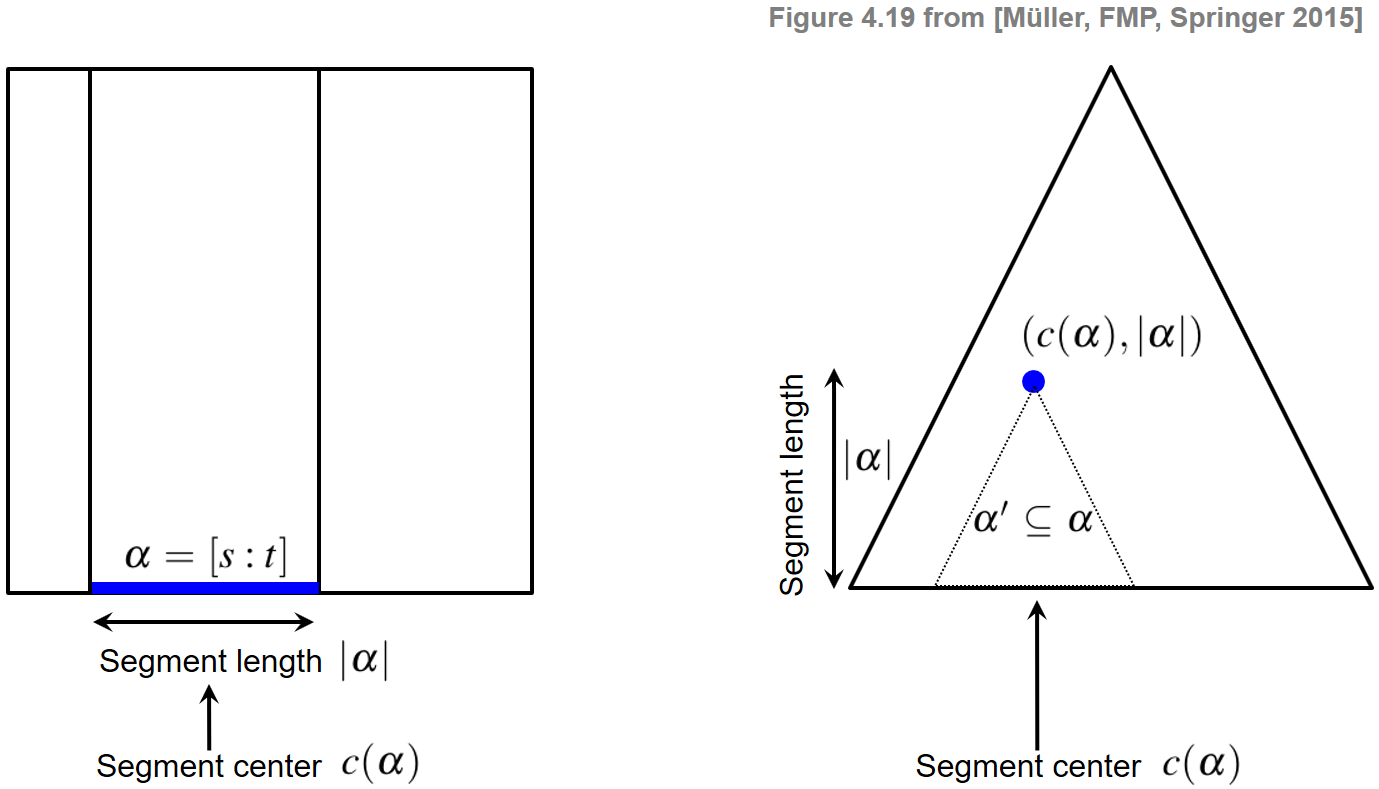

In [41]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_F19.png", width=500)

- $[1:N]$ 내의 모든 세그먼트를 삼각형으로 표현한 경우, 다음 예는 다음 세그먼트 집합을 시각적으로 나타낸다.
    - (a) 주어진 임계값 $\theta\geq 0$ 이상의 최소 길이를 갖는 모든 세그먼트
    - (b) 주어진 세그먼트 $\alpha$를 포함하는 모든 세그먼트
    - (c) 주어진 세그먼트 $\alpha$와 분리된 모든 세그먼트
    - (d) 주어진 세그먼트 $\alpha$의 중심 $c(\alpha)$를 포함하는 모든 세그먼트

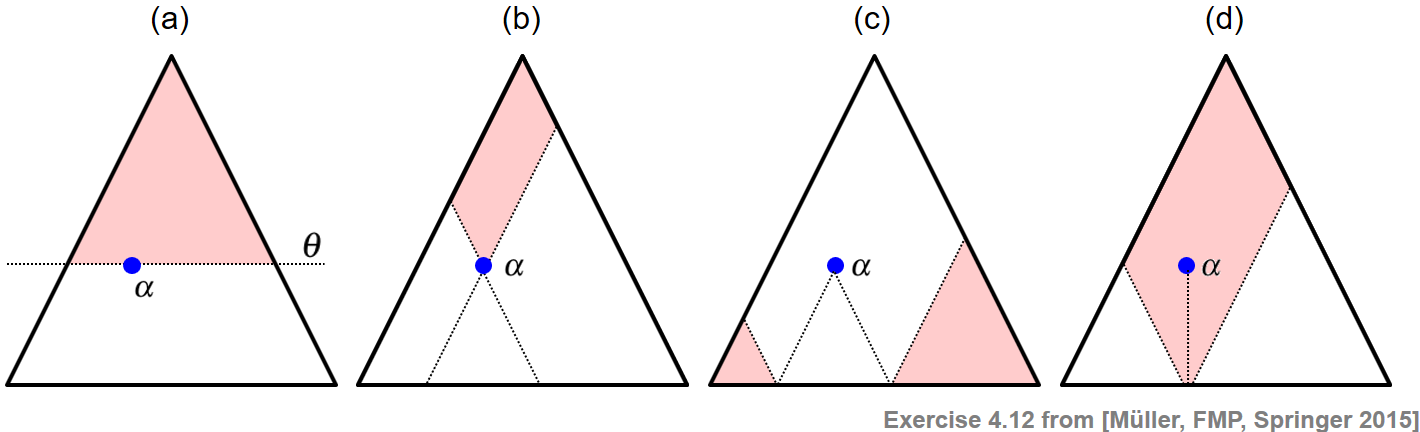

In [42]:
ipd.Image("../img/5.music_structure_analysis/FMP_C4_E12.png", width=600)

## Scape Plot

- 삼각형 표현은 모든 세그먼트 $\alpha$에 대해 계산할 수 있는 특정 숫자 속성 $\varphi(\alpha)\in\mathbb{R}$를 시각화하기 위한 그리드로 사용할 수 있다. 예를 들어 이 속성은 오디오 썸네일에 사용되는 적합성 값(fitness value)일 수 있다.
- 이러한 시각적 표현은 속성의 "**scape plot**" 표현이라고도 한다.

- 보다 정확하게는 다음을 설정하여 scape plot $\Delta$를 정의한다.
$$\label{eq:AudioStru:Thumb:SPfitness} \Delta(c(\alpha),|\alpha|):=\varphi(\alpha)$$

- 쉬운 예제로 $\alpha=[s:t]$에 대해 $\varphi(\alpha):= (t-s+1)/N$로 정의된 $\varphi$ 함수를 고려해보자. 총 길이 $N$에 대한 세그먼트 길이를 인코딩한다.

- 주의: 이 구현에서는 세그먼트 종속 속성 $\varphi(\alpha)\in\mathbb{R}$을 저장하기 위한 데이터 구조로 `N`-스퀘어 행렬 `SP`를 사용한다. 길이를 인코딩하기 위해 `SP`의 첫 번째 차원을 사용하고 중심을 인코딩하기 위해 두 번째 차원을 사용한다. Python의 인덱싱은 인덱스 `0`부터 시작하므로 길이 차원을 해석할 때 주의해야 한다. 특히, 엔트리 `SP[length_minus_one, start]`는 `length_minus_one = 0, ..., N-1`에 대해 `length_minus_one + 1`의 길이를 갖는 세그먼트에 대한 정보를 포함한다. 또한 `SP`는 왼쪽 위 부분(대각선 포함)만 사용한다는 점에 유의해야 한다.

In [43]:
def visualize_scape_plot(SP, Fs=1, ax=None, figsize=(4, 3), title='',
                         xlabel='Center (seconds)', ylabel='Length (seconds)', interpolation='nearest'):
    """Visualize scape plot

    Args:
        SP: Scape plot data (encodes as start-duration matrix)
        Fs: Sampling rate (Default value = 1)
        ax: Used axes (Default value = None)
        figsize: Figure size (Default value = (4, 3))
        title: Title of figure (Default value = '')
        xlabel: Label for x-axis (Default value = 'Center (seconds)')
        ylabel: Label for y-axis (Default value = 'Length (seconds)')
        interpolation: Interpolation value for imshow (Default value = 'nearest')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.gca()
    N = SP.shape[0]
    SP_vis = np.zeros((N, N))
    for length_minus_one in range(N):
        for start in range(N-length_minus_one):
            center = start + length_minus_one//2
            SP_vis[length_minus_one, center] = SP[length_minus_one, start]

    extent = np.array([-0.5, (N-1)+0.5, -0.5, (N-1)+0.5]) / Fs
    im = plt.imshow(SP_vis, cmap='hot_r', aspect='auto', origin='lower', extent=extent, interpolation=interpolation)
    x = np.asarray(range(N))
    x_half_lower = x/2
    x_half_upper = x/2 + N/2 - 1/2
    plt.plot(x_half_lower/Fs, x/Fs, '-', linewidth=3, color='black')
    plt.plot(x_half_upper/Fs, np.flip(x, axis=0)/Fs, '-', linewidth=3, color='black')
    plt.plot(x/Fs, np.zeros(N)/Fs, '-', linewidth=3, color='black')
    plt.xlim([0, (N-1) / Fs])
    plt.ylim([0, (N-1) / Fs])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.colorbar(im, ax=ax)
    return fig, ax, im

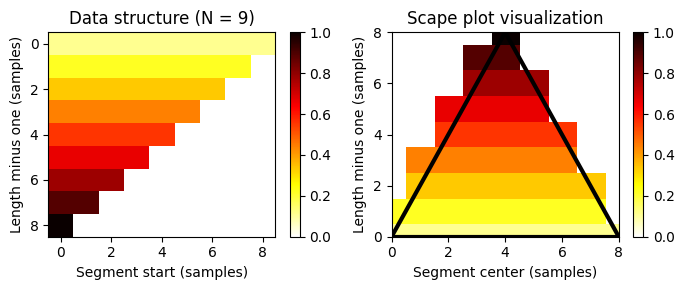

In [44]:
N = 9
SP = np.zeros((N,N))
for k in range(N):
    for s in range(N-k):
        length = k + 1
        SP[k, s]= length/N  

plt.figure(figsize=(7,3))
ax = plt.subplot(121)
plt.imshow(SP, cmap='hot_r', aspect='auto') 
ax.set_title('Data structure (N = %d)'%N)
ax.set_xlabel('Segment start (samples)')
ax.set_ylabel('Length minus one (samples)')
plt.colorbar()  

ax = plt.subplot(122)
fig, ax, im = visualize_scape_plot(SP, Fs=1, ax=ax, title='Scape plot visualization', 
                xlabel='Segment center (samples)', ylabel='Length minus one (samples)')

## 적합도 Scape Plot

- scape plot 표현을 사용해 모든 세그먼트에 대한 적합도 측정을 시각화한다.

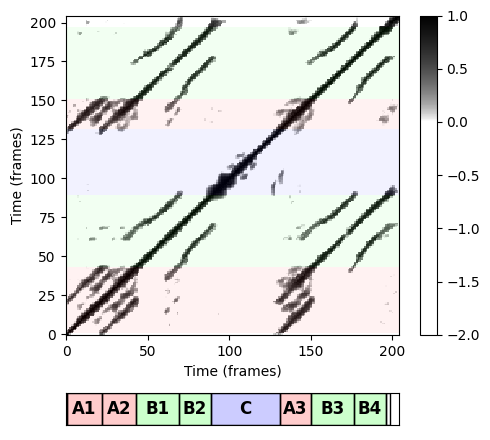

In [45]:
fn_wav = '../data_FMP/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.wav'

tempo_rel_set = compute_tempo_rel_set(0.66, 1.5, 5)
penalty = -2
x, x_duration, X, Fs_feature, S, I = compute_sm_from_filename(fn_wav, L=41, H=10, 
                        L_smooth=8, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh= 0.15)
S = normalization_properties_ssm(S)
 
fn_ann = '../data_FMP/FMP_C4_Audio_Brahms_HungarianDances-05_Ormandy.csv'
ann_frames, color_ann = read_structure_annotation(fn_ann, Fs=Fs_feature)

cmap_penalty = colormap_penalty(penalty=penalty)
fig, ax, im = plot_ssm_ann(S, ann_frames, Fs=1, color_ann=color_ann, cmap=cmap_penalty, 
                       xlabel='Time (frames)', ylabel='Time (frames)')

- 다음 코드는 세그먼트 $\alpha$에 대한 적합도 척도 $\varphi(\alpha)\in\mathbb{R}$ (및 점수 $\sigma(\alpha)$, 정규화된 점수 $\bar{\sigma}(\alpha)$, 커버리지(coverage) $\gamma(\alpha)$, 정규화된 커버리지 $\bar{\gamma}(\alpha)$)를 계산한다.

In [46]:
def compute_fitness_scape_plot(S):
    """Compute scape plot for fitness and other measures

    Args:
        S (np.ndarray): Self-similarity matrix

    Returns:
        SP_all (np.ndarray): Vector containing five different scape plots for five measures
            (fitness, score, normalized score, coverage, normlized coverage)
    """
    N = S.shape[0]
    SP_fitness = np.zeros((N, N))
    SP_score = np.zeros((N, N))
    SP_score_n = np.zeros((N, N))
    SP_coverage = np.zeros((N, N))
    SP_coverage_n = np.zeros((N, N))

    for length_minus_one in range(N):
        for start in range(N-length_minus_one):
            S_seg = S[:, start:start+length_minus_one+1]
            D, score = compute_accumulated_score_matrix(S_seg)
            path_family = compute_optimal_path_family(D)
            fitness, score, score_n, coverage, coverage_n, path_family_length = compute_fitness(
                path_family, score, N)
            SP_fitness[length_minus_one, start] = fitness
            SP_score[length_minus_one, start] = score
            SP_score_n[length_minus_one, start] = score_n
            SP_coverage[length_minus_one, start] = coverage
            SP_coverage_n[length_minus_one, start] = coverage_n
    SP_all = [SP_fitness, SP_score, SP_score_n, SP_coverage, SP_coverage_n]
    return SP_all

In [47]:
SP_all = compute_fitness_scape_plot(S)

- 다음으로 **적합도 scape plot**라고도 하는 scape plot 표현을 사용하여 적합성 값 $\varphi(\alpha)$를 시각화한다.
- 또한 경로군 및 유도된 세그먼트에 걸쳐 적합도-최대화 세그먼트 또는 오디오 썸네일 $\alpha^\ast := \underset{\alpha}{\mathrm{argmax}} \,\, \varphi(\alpha)$를 그린다.

- 썸네일과 유도된 세그먼트는 scape plot 표현에서 점(각각 파란색과 녹색 점)으로 표시된다.

In [66]:
def seg_max_sp(SP):
    """Return segment with maximal value in SP

    Args:
        SP (np.ndarray): Scape plot

    Returns:
        seg (tuple): Segment ``(start_index, end_index)``
    """
    N = SP.shape[0]
    # value_max = np.max(SP)
    arg_max = np.argmax(SP)
    ind_max = np.unravel_index(arg_max, [N, N])
    seg = [ind_max[1], ind_max[1]+ind_max[0]]
    return seg


def plot_seg_in_sp(ax, seg, S=None, Fs=1):
    """Plot segment and induced segements as points in SP visualization

    Args:
        ax: Axis for image
        seg: Segment ``(start_index, end_index)``
        S: Self-similarity matrix (Default value = None)
        Fs: Sampling rate (Default value = 1)
    """
    if S is not None:
        S_seg = S[:, seg[0]:seg[1]+1]
        D, score = compute_accumulated_score_matrix(S_seg)
        path_family = compute_optimal_path_family(D)
        segment_family, coverage = compute_induced_segment_family_coverage(path_family)
        length = segment_family[:, 1] - segment_family[:, 0] + 1
        center = segment_family[:, 0] + length//2
        ax.scatter(center/Fs, length/Fs, s=64, c='white', zorder=9999)
        ax.scatter(center/Fs, length/Fs, s=16, c='lime', zorder=9999)
    length = seg[1] - seg[0] + 1
    center = seg[0] + length//2
    ax.scatter(center/Fs, length/Fs, s=64, c='white', zorder=9999)
    ax.scatter(center/Fs, length/Fs, s=16, c='blue', zorder=9999)

    
def plot_sp_ssm(SP, seg, S, ann, color_ann=[], title='', figsize=(5, 4)):
    """Visulization of SP and SSM

    Args:
        SP: Scape plot
        seg: Segment ``(start_index, end_index)``
        S: Self-similarity matrix
        ann: Annotation
        color_ann: color scheme used for annotations (Default value = [])
        title: Title of figure (Default value = '')
        figsize: Figure size (Default value = (5, 4))
    """
    fig, ax, im = visualize_scape_plot(SP, figsize=figsize, title=title,
                                       xlabel='Center (frames)', ylabel='Length (frames)')
    plot_seg_in_sp(ax, seg, S)

    penalty = np.min(S)
    cmap_penalty = colormap_penalty(penalty=penalty)
    fig, ax, im = plot_ssm_ann_optimal_path_family(
        S, ann, seg, color_ann=color_ann, fontsize=8, cmap=cmap_penalty, figsize=(4, 4),
        ylabel='Time (frames)')

    
    
def check_segment(seg, S):
    """Prints properties of segments with regard to SSM ``S``

    Args:
        seg (tuple): Segment ``(start_index, end_index)``
        S (np.ndarray): Self-similarity matrix

    Returns:
         path_family (list): Optimal path family
    """
    N = S.shape[0]
    S_seg = S[:, seg[0]:seg[1]+1]
    D, score = compute_accumulated_score_matrix(S_seg)
    path_family = compute_optimal_path_family(D)
    fitness, score, score_n, coverage, coverage_n, path_family_length = compute_fitness(
                path_family, score, N)
    segment_family, coverage2 = compute_induced_segment_family_coverage(path_family)
    print('Segment (alpha):', seg)
    print('Length of segment:', seg[-1]-seg[0]+1)
    print('Length of feature sequence:', N)
    print('Induced segment path family:\n', segment_family)
    print('Fitness: %0.10f' % fitness)
    print('Score: %0.10f' % score)
    print('Normalized score: %0.10f' % score_n)
    print('Coverage: %d, %d' % (coverage, coverage2))
    print('Normalized coverage: %0.10f' % coverage_n)
    print('Length of all paths of family: %d' % path_family_length)
    return path_family

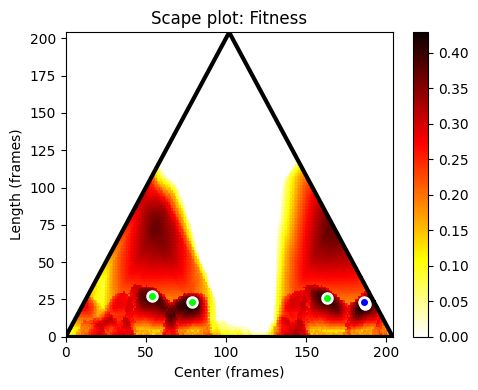

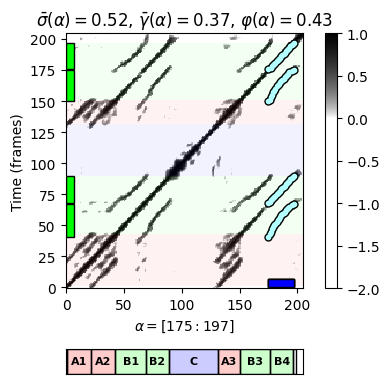

Segment (alpha): [175, 197]
Length of segment: 23
Length of feature sequence: 205
Induced segment path family:
 [[ 41  67]
 [ 68  90]
 [150 175]
 [176 197]]
Fitness: 0.4286698291
Score: 68.0249475309
Normalized score: 0.5175281325
Coverage: 98, 98
Normalized coverage: 0.3658536585
Length of all paths of family: 87


In [67]:
figsize=(5,4)
SP = SP_all[0]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Fitness', figsize=figsize)
plt.show()
path_family = check_segment(seg, S)

- 결과의 적합도 scape plot는 계층적 방식으로 음악적 구조를 반영한다.

- **썸네일 세그먼트**는 $\alpha^\ast=[175:197]$이며 음악적으로 $B_4$ 부분에 해당한다.

- scape plot의 좌표는 중심 $c(\alpha)=186$ 및 길이 $|\alpha|=23$로 지정된다.

- **유도된 세그먼트** 군은 4개의 $B$ 부분으로 구성된다. 네 개의 $B$ 부분 세그먼트는 모두 거의 동일한 적합성을 가지며 거의 동일한 세그먼트 군으로 이어진다.

- 적합도 측정은 짧은 세그먼트를 조금 더 선호한다. 따라서 이 녹음에서 $B_4$-파트가 $B_1$-파트보다 빠르게 재생되기 때문에 적합도 측정은 $B_1$-파트 세그먼트보다 $B_4$-파트 세그먼트를 선호한다. 즉, 이 절차는 가장 짧은 가장 대표적인 세그먼트를 썸네일로 선택하게 된다.

## 정규화된 점수와 커버리지

- 다음으로 적합도 측정의 정의에서 점수(score)와 커버리지(coverage)의 정규화(normalization)와 두 측정의 조합(조화 평균)이 매우 중요함을 설명한다.

- 이를 위해 다양한 척도(및 척도-최대화(measure-maximizing) 세그먼트)의 scape plot를 개별적으로 살펴보자.
- 점수 척도 $\sigma$를 시작한다. 점수 극대화 구간은 전체 녹음인 $\alpha=[1:N]$ 이다.

Segment (alpha): [0, 204]
Length of segment: 205
Length of feature sequence: 205
Induced segment path family:
 [[  0 204]]
Fitness: 0.0000000000
Score: 205.0000000000
Normalized score: 0.0000000000
Coverage: 205, 205
Normalized coverage: 0.0000000000
Length of all paths of family: 205


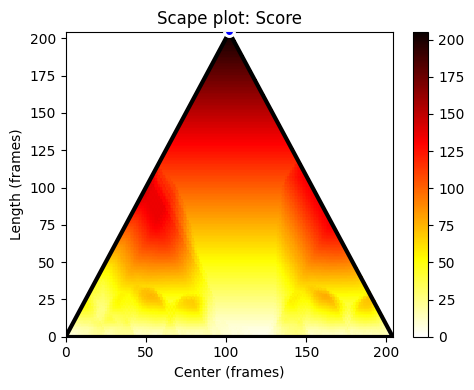

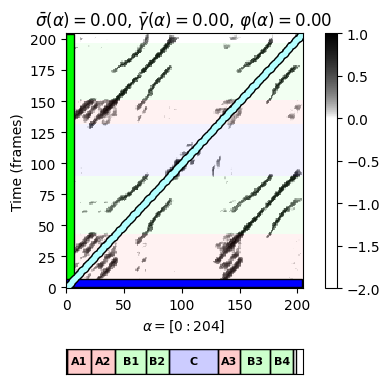

In [68]:
SP = SP_all[1]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Score', figsize=figsize)
path_family = check_segment(seg, S)

- 사소한(trivial) 자기-설명을 빼고 최적 경로군의 길이에 대해 정규화하면 **정규화 점수** $\bar{\sigma}$가 된다.

- 이 척도는 오디오 자료가 실제로 얼마나 커버되는지를 나타내지 않고 경로군의 평균 점수를 나타내므로, 많은 작은 세그먼트가 상대적으로 높은 점수를 얻는다. 이러한 측정을 사용하면 일반적으로 짧은 길이의 false-positive 세그먼트가 생성된다.
- 이는 다음과 같은 scape plot와 $\bar{\sigma}$-최대화 경로 군으로도 증명된다.

Segment (alpha): [183, 188]
Length of segment: 6
Length of feature sequence: 205
Induced segment path family:
 [[ 54  61]
 [ 76  81]
 [163 168]
 [183 188]]
Fitness: 0.1680842515
Score: 20.5560875887
Normalized score: 0.6065036495
Coverage: 26, 26
Normalized coverage: 0.0975609756
Length of all paths of family: 24


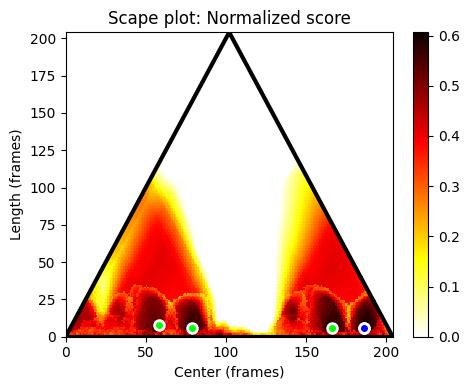

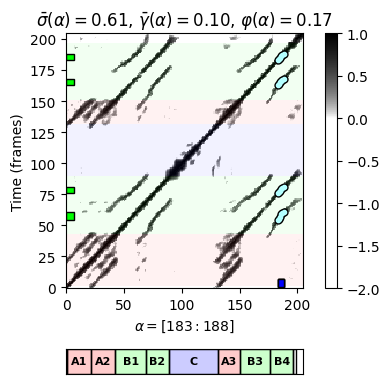

In [69]:
SP = SP_all[2]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Normalized score', figsize=figsize)
path_family = check_segment(seg, S)

- 다음 그림은 커버리지 측정 $\gamma$에 대한 scape plot를 보여준다. 악보의 경우 커버리지-최대화 세그먼트는 $\alpha=[1:N]$로 전체 녹음이다.

Segment (alpha): [91, 204]
Length of segment: 114
Length of feature sequence: 205
Induced segment path family:
 [[  0  92]
 [ 93 204]]
Fitness: 0.1205736958
Score: 128.2312820570
Normalized score: 0.0697611866
Coverage: 205, 205
Normalized coverage: 0.4439024390
Length of all paths of family: 204


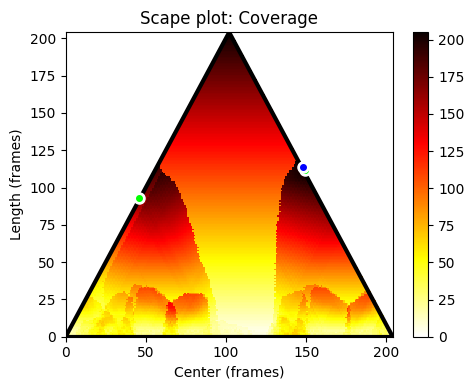

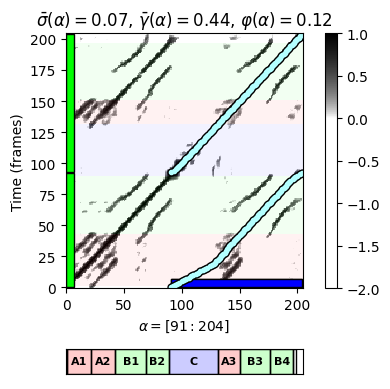

In [70]:
SP = SP_all[3]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Coverage', figsize=figsize)
path_family = check_segment(seg, S)

- trivial한 자기-설명을 빼고 길이 $N$에 대해 정규화하면 **정규화 커버리지** $\bar{\gamma}$가 된다.
- $\bar{\gamma}$-최대화 세그먼트와 함께 다음 scape plot에서 볼 수 있듯이, 커버리지(coverage)는 점수(score)와는 개념적으로 다른 속성을 측정한다. 정규화된 점수와 달리, 정규화된 커버리지는 일반적으로 입력 시퀀스의 많은 부분을 차지하는 세그먼트군을 유도하는 세그먼트를 선호한다.

Segment (alpha): [56, 76]
Length of segment: 21
Length of feature sequence: 205
Induced segment path family:
 [[ 32  55]
 [ 56  76]
 [ 77  94]
 [140 163]
 [164 184]
 [185 204]]
Fitness: 0.3370126389
Score: 50.3634037795
Normalized score: 0.2488424049
Coverage: 128, 128
Normalized coverage: 0.5219512195
Length of all paths of family: 118


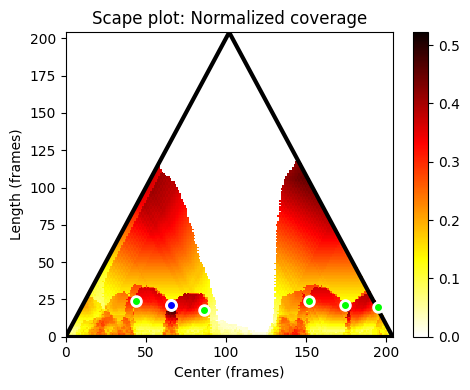

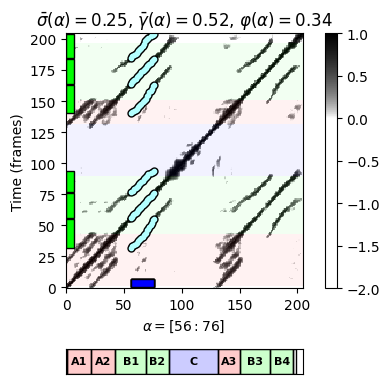

In [71]:
SP = SP_all[4]
seg = seg_max_sp(SP)
plot_sp_ssm(SP=SP, seg=seg, S=S, ann=ann_frames, color_ann=color_ann, 
            title='Scape plot: Normalized coverage', figsize=figsize)
path_family = check_segment(seg, S)

# 최적 경로군의 예시

- Brahms 예의 오디오 썸네일 $\alpha^\ast$를 계산해보자.
- $(N+1)N/2$개의 가능한 세그먼트 $\alpha \subseteq [1:N]$가 있으며, 따라서 $\alpha^\ast$를 결정하는 것은 시간이 많이 걸리는 작업이다.
     * 다음에서는 `libfmp.c4.compute_fitness_scape_plot` 함수를 적용하여 모든 세그먼트의 적합도를 계산하며, 데이터 구조 `SP=SP_all[0]`에 저장된다.
     * `libfmp.c4.seg_max_sp` 함수를 사용하면 `SP`로부터 적합도-최대화 세그먼트를 결정할 수 있다.
     * `libfmp.c4.check_segment` 함수는 썸네일 세그먼트 $\alpha \ast$의 속성을 출력한다.

In [49]:
def plot_ssm_ann_optimal_path_family(S, ann, seg, Fs=1, cmap='gray_r', color_ann=[], fontsize=12,
                                     figsize=(5, 4.5), ylabel=''):
    """Plot SSM, annotations, and computed optimal path family

    Args:
        S: Self-similarity matrix
        ann: Annotations
        seg: Segment for computing the optimal path family
        Fs: Feature rate of path_family (Default value = 1)
        cmap: Color map for S (Default value = 'gray_r')
        color_ann: color scheme used for annotations (see :func:`libfmp.b.b_plot.plot_segments`)
            (Default value = [])
        fontsize: Font size used for annotation labels (Default value = 12)
        figsize: Size of figure (Default value = (5, 4.5))
        ylabel: Label for y-axis (Default value = '')

    Returns:
        fig: Handle for figure
        ax: Handle for axes
        im: Handle for imshow
    """
    N = S.shape[0]
    S_seg = S[:, seg[0]:seg[1]+1]
    D, score = compute_accumulated_score_matrix(S_seg)
    path_family = compute_optimal_path_family(D)
    fitness, score, score_n, coverage, coverage_n, path_family_length = compute_fitness(
        path_family, score, N)
    title = r'$\bar{\sigma}(\alpha)=%0.2f$, $\bar{\gamma}(\alpha)=%0.2f$, $\varphi(\alpha)=%0.2f$' % \
            (score_n, coverage_n, fitness)
    fig, ax, im = plot_ssm_ann(S, ann, color_ann=color_ann, Fs=Fs, cmap=cmap,
                               figsize=figsize, fontsize=fontsize,
                               xlabel=r'$\alpha=[%d:%d]$' % (seg[0], seg[-1]), ylabel=ylabel, title=title)
    plot_path_family(ax[0, 0], path_family, Fs=Fs, x_offset=seg[0])
    return fig, ax, im

In [50]:
tempo_rel_set = compute_tempo_rel_set(0.66, 1.5, 5)
penalty = -2
x, x_duration, X, Fs_feature, S, I = compute_sm_from_filename(fn_wav, L=21, H=5, 
                        L_smooth=12, tempo_rel_set=tempo_rel_set, penalty=penalty, thresh= 0.15)

S = normalization_properties_ssm(S)

ann_frames, color_ann = read_structure_annotation(fn_ann, Fs=Fs_feature)

In [53]:
# SP_all = compute_fitness_scape_plot(S) 
# SP = SP_all[0]
# seg = seg_max_sp(SP)
# fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,
#                     color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')
# plt.show()
# path_family = check_segment(seg, S)

# 오래걸리기 때문에 사진을 불러와 출력값을 보자.

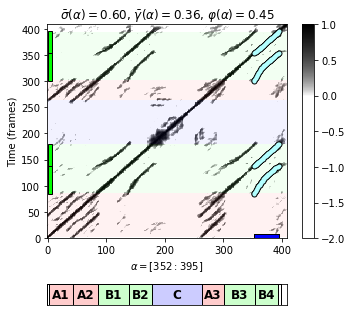

In [56]:
ipd.Image("../img/5.music_structure_analysis/5.3.3.output1.png", width=500)

- 적합도-최대화 세그먼트는 $\alpha^\ast=[353:396]$ (`seg = [352, 395]`) with $\varphi(\alpha^\ast)=0.452$로 주어진다.
- 음악적으로 $B_4$ 파트($176$와 $197.5$ 사이의 간격)에 해당하는 이 세그먼트는 실제로 가장 반복적인 부분이다.
- 유도된 세그먼트 군은 4개의 $B$ 부분 세그먼트로 구성된다.

In [57]:
# seg = [84, 137]
# fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,  
#               color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')

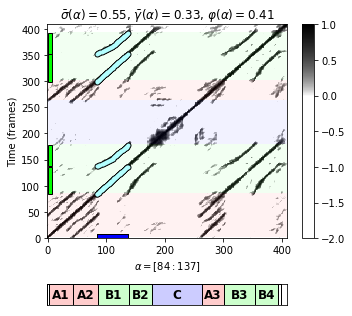

In [58]:
ipd.Image("../img/5.music_structure_analysis/5.3.3.output2.png", width=500)

- 4개의 $B$ 부분 세그먼트가 모두 거의 동일한 적합도를 가지고 있고 거의 동일한 세그먼트군으로 이어지는 것을 확인할 수 있다. 예를 들어 $B_1$ 부분에 해당하는 $\alpha=[85:138]$ (`seg = [84, 137]`) (초 $42$와 $69$ 사이의 간격)을 보면, 적합도는 $\varphi(\alpha)=0.41$이며 가능한 최대-적합도보다 약간 낮다. 
- 다시, 유도된 세그먼트군은 4개의 $B$ 부분 세그먼트로 구성되며, 이는 각각의 $B$ 부분 세그먼트가 썸네일과 똑같이 잘 작동할 수 있다는 사실을 반영한다. 적합도 측정은 짧은 세그먼트를 약간 선호하고 이 기록에서 $B_4$-파트가 $B_1$-파트보다 빠르게 재생되기 때문에 적합도 측정은 $B_1$-파트 세그먼트보다 $B_4$-파트 세그먼트를 선호한다.

In [62]:
# seg = [260, 306]
# fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,  
#                 color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')
# plt.show()
# path_family = check_segment(seg, S)

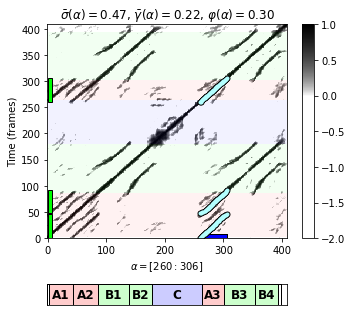

In [63]:
ipd.Image("../img/5.music_structure_analysis/5.3.3.output3.png", width=500)

- 또한 다른 세그먼트는 높은 적합도 값을 가질 수 있고, 다른 반복 세그먼트와 높은 유사성을 나타낸다. 예를 들어, $A_3$ 부분에 해당하는 세그먼트 $\alpha=[261:307]$ (`seg = [260, 306]`, 초 $130$와 $153$ 사이의 간격)의 적합도는 다음과 같다. $\varphi(\alpha)=0.30$. 유도 세그먼트 군은 세 개의 $A$ 부분을 나타낸다.

In [59]:
# seg = [41, 180]
# fig, ax, im = plot_ssm_ann_optimal_path_family(S, ann_frames, seg,  
#                 color_ann=color_ann, cmap=cmap_penalty, ylabel='Time (frames)')
# plt.show()
# path_family = check_segment(seg, S)

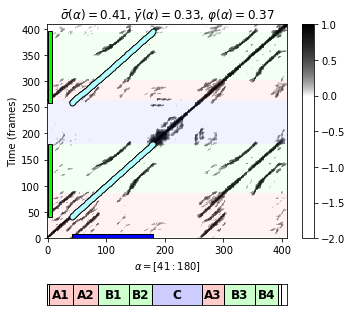

In [61]:
ipd.Image("../img/5.music_structure_analysis/5.3.3.output4.png", width=500)

- 마지막 예로, $\alpha=[42:181]$ (`seg = [41, 180]`, $20.5$와 $90$ 사이의 간격) 세그먼트를 보자. 이 세그먼트는 $A_2B_1B_2$에 해당하며 $A_3B_3B_4$로 반복된다. 다시 말하지만, 자기-설명이 무시되는 정규화 때문에 다소 긴 세그먼트 $\alpha=[42:181]$ (`seg = [41, 180]`)의 적합도 $\varphi(\alpha)=0.37$는 썸네일 $\alpha^\ast=[353:396]$ (`seg = [352, 395]`)의 적합도 $\varphi(\alpha^\ast)=0.45$보다 훨씬 낮다.

---

출처: 

- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4S3_AudioThumbnailing.html


---

[구글 Colab 링크](https://colab.research.google.com/github/jo-cho/mir_kr/blob/main/Notebooks/5.%20Music%20Structure%20Analysis/5.2.Self_Similarity_Matrix.ipynb)